In [1]:
shape_cat=""
vol=""
z_range=""
key=""
quantile=""

In [2]:
# Parameters
shape_cat = "mcal"
vol = "vlim"
z_range = "all_z"
key = "lambda"
quantile = "2"


In [3]:
#This header file contains all the common packages
%matplotlib inline
%run /home/cz136/project/sa/lib/src/header.py $shape_cat $vol $z_range 
%run -i /home/cz136/project/sa/lib/src/func.py  

In [4]:
if quantile!="":
    i=int(quantile)

In [5]:
if key=="lambda":
    key=('All','All','LAMBDA_CHISQ')
elif key=="z":
    key=('All','All','Z_LAMBDA')

In [6]:
def thirds_by_key(catalog,key):
    step0=catalog[key].quantile(0.0)
    step1=catalog[key].quantile(0.333333)
    step2=catalog[key].quantile(0.666666)
    step3=catalog[key].quantile(1)
    
    catalog1=catalog[(catalog[key]>step0) & (catalog[key]<step1)]
    catalog2=catalog[(catalog[key]>step1) & (catalog[key]<step2)]
    catalog3=catalog[(catalog[key]>step2) & (catalog[key]<step3)]
    
    return (catalog1,catalog2,catalog3)

In [7]:
if key!="":
    clusters_list=thirds_by_key(clusters,key)
    clusters=clusters_list[i]

In [8]:
sep="------------------------------------------------------------------------------"
np.set_printoptions(precision=4)

In [9]:
NBINS=10

In [10]:
import treecorr
import astropy.cosmology
from fastprogress import master_bar, progress_bar
from ipywidgets import FloatProgress
from IPython.display import display
from tqdm import tqdm

In [11]:
if key=="":
    assert np.isin(shapes['All','MEM_MATCH_ID'].to_numpy(),clusters.index.to_numpy()).all()==True

In [12]:
def get_ng(cluster,mode1,mode2):
    if mode2=="abs":
        UPPER_BOUND=np.max(shapes[('All','R')])
        distance=('All','angR')
        
    elif mode2=="rel":
        UPPER_BOUND=1.2
        distance=('All','normLR')
    else:
        raise

    if mode1 == "s":
        def get_cluster_cen(cluster):
            return (get_unique_center_for_cluster(cluster))
        def get_cluster_sats(cluster):
            cen_mat_id=cluster.name
            cen_id=cluster[('Alt','Alt1','ID_CENT')]
            sats=shapes[shapes['All','MEM_MATCH_ID']==cen_mat_id]
            sats=sats[sats.index!=cen_id]
            return (sats)
    elif mode1=='r':
        def get_cluster_sats(cluster):
            return(shapes)
        def get_cluster_cen(cluster):
            return (random)

    else:
        raise


    cen=get_cluster_cen(cluster)
    sats=get_cluster_sats(cluster)


    sats_e1=sats[('All','e1')].to_numpy()
    sats_e2=sats[('All','e2')].to_numpy()
    sats_angr=sats[distance]

#     print(sats_e1,sats_e2)

    if type(cen[('All','RA')])==np.float64:
        cen_angr=np.array(cen[distance]).reshape(1)
        cen_ra=np.array(cen[('All','RA')]).reshape(1)
        cen_dec=np.array(cen[('All','DEC')]).reshape(1)
    else:
#         cen_e1=cen[('All','e1')].to_numpy
#         cen_e2=cen[('All','e2')].to_numpy()
        cen_angr=cen[distance].to_numpy()
        cen_ra=cen[('All','RA')].to_numpy()
        cen_dec=cen[('All','DEC')].to_numpy()




#     print(cen_e1,cen_e2)

    sats_ra=sats[('All','RA')].to_numpy()
    sats_dec=sats[('All','DEC')].to_numpy()




#     print(np.shape(cen_ra),np.shape(cen_dec))    
#     print(cen_ra,cen_dec)    

    sats_cat = treecorr.Catalog( g1 = sats_e1, g2   = sats_e2, 
                                 ra = sats_ra, dec = sats_dec,r=sats_angr,
                                 ra_units='deg', dec_units='deg')

    cen_cat = treecorr.Catalog( 
                                 ra = cen_ra, dec = cen_dec, r=cen_angr,
                                 ra_units='deg', dec_units='deg')

    ng = treecorr.NGCorrelation(nbins=NBINS, min_sep=0.01, max_sep=UPPER_BOUND, bin_slop=0.0,
                               metric="Rperp")
    ng.process_cross(cen_cat,sats_cat)

    return(ng)

In [13]:
def get_xi_meanlogr_varxi_npairs(cluster,mode1,mode2):
    ng=get_ng(cluster,mode1,mode2)
    return(np.array([ng.xi,ng.meanlogr,ng.varxi,ng.npairs]))

In [14]:
length=len(clusters)

def get_ng_list(mode2):
    ng_list=np.empty([length,4,NBINS])
    filler=np.zeros([1,4,NBINS])

    i=0
    e_count=0
    for index,cluster in tqdm(clusters.iterrows()):
        try:
            ng_list[i,:,:]=get_xi_meanlogr_varxi_npairs(cluster,'s',mode2)
            i=i+1
        except ValueError as e:
            ng_list[i,:,:]=filler
            i=i+1
            e_count=e_count+1
    print("Number of empty sat catalogs is {}".format(e_count))
    return (ng_list)

In [15]:
ng_abs=get_ng_list('abs')
ng_rel=get_ng_list('rel')

0it [00:00, ?it/s]

1it [00:00,  6.34it/s]

11it [00:00,  8.81it/s]

20it [00:00, 12.04it/s]

33it [00:00, 16.53it/s]

43it [00:00, 21.99it/s]

56it [00:00, 29.27it/s]

67it [00:00, 37.30it/s]

79it [00:00, 46.88it/s]

92it [00:00, 57.76it/s]

105it [00:01, 69.23it/s]

118it [00:01, 80.20it/s]

132it [00:01, 90.72it/s]

145it [00:01, 96.45it/s]

158it [00:01, 104.39it/s]

171it [00:01, 103.95it/s]

183it [00:01, 107.44it/s]

196it [00:01, 113.04it/s]

210it [00:01, 117.61it/s]

223it [00:02, 120.98it/s]

236it [00:02, 123.36it/s]

249it [00:02, 124.36it/s]

262it [00:02, 125.92it/s]

276it [00:02, 127.53it/s]

289it [00:02, 127.41it/s]

302it [00:02, 127.93it/s]

315it [00:02, 128.40it/s]

329it [00:02, 129.20it/s]

342it [00:02, 129.02it/s]

355it [00:03, 128.62it/s]

368it [00:03, 128.97it/s]

381it [00:03, 128.05it/s]

394it [00:03, 127.61it/s]

407it [00:03, 127.37it/s]

420it [00:03, 110.96it/s]

433it [00:03, 115.14it/s]

446it [00:03, 118.87it/s]

460it [00:03, 122.28it/s]

473it [00:04, 123.54it/s]

486it [00:04, 122.01it/s]

499it [00:04, 104.51it/s]

512it [00:04, 110.01it/s]

525it [00:04, 114.02it/s]

537it [00:04, 113.23it/s]

551it [00:04, 118.29it/s]

564it [00:04, 121.31it/s]

577it [00:04, 123.31it/s]

590it [00:05, 124.93it/s]

603it [00:05, 126.20it/s]

616it [00:05, 117.03it/s]

629it [00:05, 120.32it/s]

642it [00:05, 121.65it/s]

655it [00:05, 123.21it/s]

668it [00:05, 123.73it/s]

681it [00:05, 115.92it/s]

693it [00:05, 104.55it/s]

707it [00:06, 111.43it/s]

721it [00:06, 116.66it/s]

735it [00:06, 120.47it/s]

748it [00:06, 122.03it/s]

761it [00:06, 123.00it/s]

774it [00:06, 120.78it/s]

787it [00:06, 120.35it/s]

800it [00:06, 122.79it/s]

814it [00:06, 124.91it/s]

827it [00:07, 119.95it/s]

840it [00:07, 113.20it/s]

853it [00:07, 117.44it/s]

866it [00:07, 120.58it/s]

879it [00:07, 123.26it/s]

893it [00:07, 125.19it/s]

906it [00:07, 125.45it/s]

919it [00:07, 125.10it/s]

933it [00:07, 127.36it/s]

946it [00:08, 122.92it/s]

959it [00:08, 120.17it/s]

973it [00:08, 123.18it/s]

986it [00:08, 94.38it/s] 

998it [00:08, 100.83it/s]

1009it [00:08, 98.40it/s]

1022it [00:08, 104.34it/s]

1035it [00:08, 109.87it/s]

1048it [00:08, 114.61it/s]

1061it [00:09, 116.80it/s]

1073it [00:09, 113.42it/s]

1086it [00:09, 117.00it/s]

1099it [00:09, 119.97it/s]

1112it [00:09, 120.81it/s]

1125it [00:09, 123.08it/s]

1138it [00:09, 125.02it/s]

1151it [00:09, 126.07it/s]

1165it [00:09, 127.39it/s]

1178it [00:10, 127.70it/s]

1191it [00:10, 125.96it/s]

1204it [00:10, 127.12it/s]

1217it [00:10, 124.89it/s]

1230it [00:10, 124.17it/s]

1243it [00:10, 121.49it/s]

1256it [00:10, 123.37it/s]

1269it [00:10, 124.22it/s]

1282it [00:10, 119.25it/s]

1295it [00:10, 121.98it/s]

1308it [00:11, 122.79it/s]

1321it [00:11, 121.87it/s]

1334it [00:11, 123.92it/s]

1348it [00:11, 125.86it/s]

1361it [00:11, 126.39it/s]

1375it [00:11, 127.93it/s]

1388it [00:11, 124.54it/s]

1401it [00:11, 124.61it/s]

1414it [00:11, 123.37it/s]

1428it [00:12, 125.35it/s]

1438it [00:12, 118.81it/s]


0it [00:00, ?it/s]

9it [00:00, 83.90it/s]

Number of empty sat catalogs is 0


18it [00:00, 83.53it/s]

31it [00:00, 93.39it/s]

41it [00:00, 93.50it/s]

55it [00:00, 102.39it/s]

69it [00:00, 109.85it/s]

83it [00:00, 115.88it/s]

95it [00:00, 112.26it/s]

107it [00:00, 111.68it/s]

121it [00:01, 116.82it/s]

134it [00:01, 120.47it/s]

147it [00:01, 123.11it/s]

161it [00:01, 125.72it/s]

175it [00:01, 127.07it/s]

188it [00:01, 117.61it/s]

201it [00:01, 120.38it/s]

214it [00:01, 120.73it/s]

227it [00:01, 122.05it/s]

240it [00:02, 122.77it/s]

253it [00:02, 105.69it/s]

265it [00:02, 100.31it/s]

279it [00:02, 108.03it/s]

293it [00:02, 114.70it/s]

307it [00:02, 119.58it/s]

321it [00:02, 123.82it/s]

335it [00:02, 126.87it/s]

349it [00:02, 129.89it/s]

363it [00:03, 131.27it/s]

377it [00:03, 132.00it/s]

391it [00:03, 128.40it/s]

405it [00:03, 129.37it/s]

419it [00:03, 131.07it/s]

433it [00:03, 131.33it/s]

447it [00:03, 131.94it/s]

461it [00:03, 112.09it/s]

474it [00:03, 115.10it/s]

488it [00:04, 120.38it/s]

502it [00:04, 123.81it/s]

516it [00:04, 128.05it/s]

530it [00:04, 129.92it/s]

544it [00:04, 131.65it/s]

558it [00:04, 133.29it/s]

572it [00:04, 129.06it/s]

585it [00:04, 120.45it/s]

599it [00:04, 124.57it/s]

612it [00:05, 126.04it/s]

626it [00:05, 128.67it/s]

640it [00:05, 131.03it/s]

654it [00:05, 132.85it/s]

668it [00:05, 133.27it/s]

682it [00:05, 133.37it/s]

696it [00:05, 131.00it/s]

710it [00:05, 128.51it/s]

724it [00:05, 129.75it/s]

738it [00:05, 131.69it/s]

752it [00:06, 132.58it/s]

766it [00:06, 133.15it/s]

780it [00:06, 134.09it/s]

794it [00:06, 121.87it/s]

807it [00:06, 122.14it/s]

820it [00:06, 113.21it/s]

832it [00:06, 101.49it/s]

843it [00:06, 97.89it/s] 

856it [00:07, 105.72it/s]

870it [00:07, 112.33it/s]

884it [00:07, 118.62it/s]

898it [00:07, 123.55it/s]

912it [00:07, 126.08it/s]

926it [00:07, 129.08it/s]

940it [00:07, 124.25it/s]

953it [00:07, 124.69it/s]

966it [00:07, 125.12it/s]

979it [00:08, 124.87it/s]

992it [00:08, 124.53it/s]

1005it [00:08, 123.59it/s]

1018it [00:08, 106.06it/s]

1031it [00:08, 110.46it/s]

1043it [00:08, 102.68it/s]

1054it [00:08, 98.22it/s] 

1065it [00:08, 95.54it/s]

1075it [00:08, 91.24it/s]

1087it [00:09, 96.90it/s]

1098it [00:09, 98.65it/s]

1112it [00:09, 107.78it/s]

1126it [00:09, 114.61it/s]

1140it [00:09, 119.55it/s]

1153it [00:09, 107.19it/s]

1165it [00:09, 101.37it/s]

1177it [00:09, 102.22it/s]

1188it [00:10, 103.61it/s]

1202it [00:10, 111.50it/s]

1216it [00:10, 116.99it/s]

1228it [00:10, 103.35it/s]

1239it [00:10, 100.19it/s]

1253it [00:10, 108.32it/s]

1266it [00:10, 113.81it/s]

1280it [00:10, 118.29it/s]

1293it [00:10, 114.52it/s]

1307it [00:11, 118.95it/s]

1320it [00:11, 104.93it/s]

1335it [00:11, 113.65it/s]

1350it [00:11, 120.73it/s]

1363it [00:11, 115.56it/s]

1376it [00:11, 117.39it/s]

1389it [00:11, 115.58it/s]

1401it [00:11, 115.68it/s]

1415it [00:11, 120.15it/s]

1429it [00:12, 123.52it/s]

1438it [00:12, 118.44it/s]

Number of empty sat catalogs is 0


In [16]:
try:
    ng_r=get_xi_meanlogr_varxi_npairs(clusters,'r','abs')
except ValueError as e:
    print(e)
    ng_r=np.array([[1],[1],[1],[1]])

In [17]:
# ng_list=np.load("/home/cz136/project/sa/data/{}/ng_list_cross.npy".format(dir_string))
# ng_r=np.load("/home/cz136/project/sa/data/{}/ng_r_list_cross.npy".format(dir_string))

In [18]:
def get_sum(ng_list):
    sum_xi_cross=np.sum(ng_list[:,0,:],axis=0)
    sum_meanlogr=np.sum(ng_list[:,1,:],axis=0)
    sum_npairs=np.sum(ng_list[:,3,:],axis=0)
    return(sum_xi_cross,sum_meanlogr,sum_npairs)

def get_mean(ng_list):
    sum_xi_cross=np.sum(ng_list[:,0,:],axis=0)
    sum_meanlogr=np.sum(ng_list[:,1,:],axis=0)
    sum_npairs=np.sum(ng_list[:,3,:],axis=0)
    return(sum_xi_cross/sum_npairs,sum_meanlogr/sum_npairs)

In [19]:
def get_sigma(ng_list):
    xi_array=ng_list[:,0,:]
    npairs_array=ng_list[:,3,:]
    
    N=len(xi_array)
    
    jk_xi_array=np.empty([N,NBINS])
    
    def get_xi(drop_1_xi,drop_1_npairs):
        return(np.sum(drop_1_xi,axis=0)/np.sum(drop_1_npairs,axis=0))
    
    for i in range(N):
        drop_1_xi=np.delete(xi_array,i,axis=0)
        drop_1_npairs=np.delete(npairs_array,i,axis=0)
        jk_xi_array[i,:]=get_xi(drop_1_xi,drop_1_npairs)
        
    return(np.sqrt(N)*np.std(jk_xi_array,axis=0))

In [20]:
sum_abs=get_sum(ng_abs)
mean_abs=get_mean(ng_abs)
sig_abs=get_sigma(ng_abs)

sum_rel=get_sum(ng_rel)
mean_rel=get_mean(ng_rel)
sig_rel=get_sigma(ng_rel)

In [21]:
r_xi=ng_r[0]/ng_r[3]
r_meanlogr=ng_r[1]/ng_r[3]
r_sigma=r_xi/np.sqrt(len(clusters))

In [22]:
if key!="":
    np.savez("/home/cz136/project/sa/data/2pt/{}_{}_{}_{}.npz".format(shape_cat,vol,key,quantile),sum_abs=sum_abs,mean_abs=mean_abs,sig_abs=sig_abs,sum_rel=sum_rel,mean_rel=mean_rel,sig_rel=sig_rel,r_xi=r_xi,r_meanlogr=r_meanlogr,r_sigma=r_sigma)

In [23]:
def plt_w_error(meanlogr,xi,varxi,title):
    fig,ax=plt.subplots()
    ax.errorbar(np.exp(meanlogr),xi,yerr=varxi)
    ax.set_title(title)
    ax.set_xscale('log')
#     ax.set_ylim(-0.020,0.020)
    plt.show()
    
    if title==r"$\gamma_+$ of Clusters, Normalized by R_LAMBDA":
        plt.savefig("/home/cz136/project/sa/image/rel_{}_{}_{}.png".format(shape_cat,vol,z_range))
#     plt.xscale('log')
#     plt.yscale('log')

# Statistics

In [24]:
def print_data(sum_,mean_):
    sum_string=["Aggregated xi:", "Aggregated meanlogr:","Aggregated npairs:"]
    for i,data in enumerate(sum_):
        print(sum_string[i])
        print(sum_[i])
        print(sep)
    mean_string=["Mean xi:", "Mean meanlogr:","Mean npairs:"]
    for i,data in enumerate(mean_):
        print(mean_string[i])
        print(mean_[i])
        print(sep)

# Abs Plots

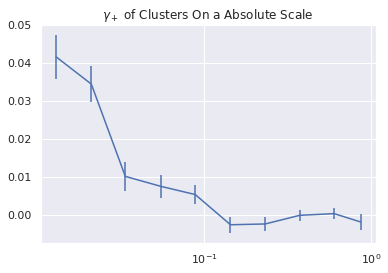

Aggregated xi:
[-12.5591 -22.391  -10.5303 -13.5447 -15.8005  13.0361  18.5037   1.411
  -3.828   11.0497]
------------------------------------------------------------------------------
Aggregated meanlogr:
[ -1308.8862  -2503.9201  -3520.1237  -5223.8931  -7167.0176  -9636.508
 -11192.4485 -10616.9176  -6378.6555   -861.1868]
------------------------------------------------------------------------------
Aggregated npairs:
[  302.   650.  1040.  1802.  2958.  4973.  7664. 10785. 12471.  5850.]
------------------------------------------------------------------------------
Mean xi:
[-0.0416 -0.0344 -0.0101 -0.0075 -0.0053  0.0026  0.0024  0.0001 -0.0003
  0.0019]
------------------------------------------------------------------------------
Mean meanlogr:
[-4.3341 -3.8522 -3.3847 -2.8989 -2.4229 -1.9378 -1.4604 -0.9844 -0.5115
 -0.1472]
------------------------------------------------------------------------------


In [25]:
plt_w_error(mean_abs[1],-mean_abs[0],sig_abs,r"$\gamma_+$ of Clusters On a Absolute Scale ")
print_data(sum_abs,mean_abs)

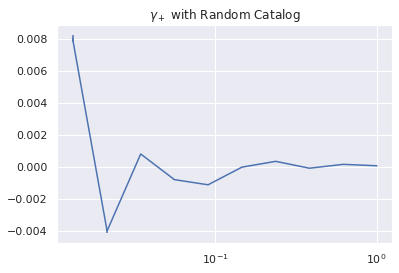

[ 8.0614e-03 -4.0169e-03  8.0985e-04 -8.0003e-04 -1.1234e-03 -1.6914e-05
  3.4635e-04 -8.3508e-05  1.5886e-04  6.9678e-05]
[-2.1259e-04  1.0593e-04 -2.1356e-05  2.1097e-05  2.9624e-05  4.4604e-07
 -9.1336e-06  2.2022e-06 -4.1892e-06 -1.8375e-06]


In [26]:
plt_w_error(r_meanlogr,-r_xi,r_sigma,r"$\gamma_+$ with Random Catalog")
print(-r_xi)
print(r_sigma)

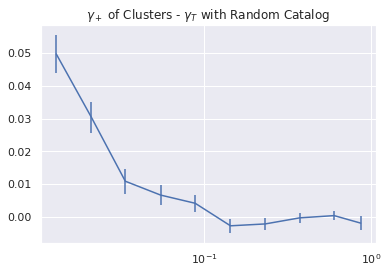

In [27]:
plt_w_error(mean_abs[1],-(mean_abs[0]+r_xi),np.hypot(r_sigma,sig_abs),r"$\gamma_+$ of Clusters - $\gamma_T$ with Random Catalog")

# Rel plots

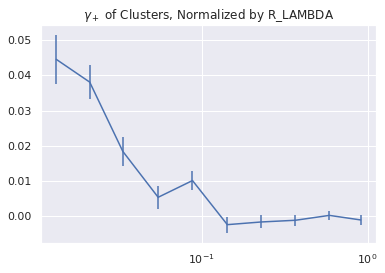

Aggregated xi:
[ -9.1762 -18.9624 -16.4058  -7.9522 -25.2953  10.0625  10.9829  11.4144
  -2.3748  11.481 ]
------------------------------------------------------------------------------
Aggregated meanlogr:
[ -889.6971 -1919.9503 -3029.5001 -4327.1732 -6088.8585 -8029.6889
 -9672.9921 -9605.7203 -6504.081  -1014.9096]
------------------------------------------------------------------------------
Aggregated npairs:
[  206.   498.   892.  1489.  2506.  4125.  6557.  9577. 12247. 10436.]
------------------------------------------------------------------------------
Mean xi:
[-0.0445 -0.0381 -0.0184 -0.0053 -0.0101  0.0024  0.0017  0.0012 -0.0002
  0.0011]
------------------------------------------------------------------------------
Mean meanlogr:
[-4.3189 -3.8553 -3.3963 -2.9061 -2.4297 -1.9466 -1.4752 -1.003  -0.5311
 -0.0973]
------------------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

In [28]:
plt_w_error(mean_rel[1],-mean_rel[0],sig_rel,r"$\gamma_+$ of Clusters, Normalized by R_LAMBDA")
print_data(sum_rel,mean_rel)